<a href="https://colab.research.google.com/github/Schlager22/FDP_Course/blob/main/Correlation_Matrices.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [11]:
import pandas as pd

df = pd.read_csv('https://raw.githubusercontent.com/fantasydatapros/LearnPythonWithFantasyFootball/master/2023/08-Correlation%20Matrices/weekly_df.csv')

df.head()


,PlayerID,Player,Position,Tm,Week,PassingYds,PassingAirYards,PassingYAC,PassingTD,Sacks,...,ReceivingEPA,Receiving2PC,TargetShare,AirYardsShare,WOPR,SpecialTeamsTD,FumblesLost,StandardFantasyPoints,PPRFantasyPoints,HalfPPRFantasyPoints
0,00-0019596,Tom Brady,QB,TB,1,212,305,87,1,2,...,NaN,0,NaN,NaN,NaN,0,0,10.38,10.38,10.38
1,00-0019596,Tom Brady,QB,TB,2,190,318,81,1,1,...,NaN,0,NaN,NaN,NaN,0,1,9.40,9.40,9.40
2,00-0019596,Tom Brady,QB,TB,3,271,236,124,1,3,...,NaN,0,NaN,NaN,NaN,0,0,14.74,14.74,14.74
3,00-0019596,Tom Brady,QB,TB,4,385,326,205,3,1,...,NaN,0,NaN,NaN,NaN,0,1,25.40,25.40,25.40
4,00-0019596,Tom Brady,QB,TB,5,351,356,178,1,0,...,NaN,0,NaN,NaN,NaN,0,0,19.74,19.74,19.74


In [6]:
"""

The unique method of the Pos series will find the unique values for our Pos column.
pandas.Series.unique documentation
https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.unique.html

"""

print(df['Position'].unique())

['QB' 'P' 'TE' 'WR' 'RB' 'ILB' 'FB' 'T' 'FS' 'SS' 'OLB' 'CB']


In [10]:
skill_positions = ['QB', 'WR', 'TE', 'RB']
"""
isin allows us to filter out row values who's given column value
is within a list of values.

pandas.Series.isin documentation

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.Series.isin.html
"""
df = df.loc[df['Position'].isin(skill_positions)]

print(df.shape)

(5495, 40)


In [16]:
"""
import numpy to leverage numpy's ufuncs.
Numpy's ufuncs are much faster than their Python equivalents, as they
leverage compiled code. For example, np.sum is much faster than Python's sum

Learn more about numpy's ufuncs here:

https://numpy.org/doc/stable/reference/ufuncs.html

"""
import numpy as np

columns = ['Player', 'Tm', 'Position', 'Week', 'HalfPPRFantasyPoints']

new_df = df[columns]

"""
the agg groupby method allows us to run different summary/aggregate functions
on different columns. Pandas will not run an aggregate function on a column
if that column is not specified in the agg arguments.

agg takes a dictionary with column names as keys and aggregate functions as values

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.agg.html

Also, setting as_index = False ensures that groupby will not keep the index after grouping.

"""
# as_index - dont set columns we are grouping by as indexes - use agg to alter value
new_df = new_df.groupby(['Player', 'Tm', 'Position'], as_index=False).agg({
    'HalfPPRFantasyPoints': np.mean# calculating the mean for FantasyPoints per game vlaues
})

new_df.head()

,Player,Tm,Position,HalfPPRFantasyPoints
0,A.J. Brown,PHI,WR,14.135000
1,A.J. Dillon,GB,RB,9.035294
2,A.J. Green,ARI,WR,3.815385
3,Aaron Jones,GB,RB,12.888235
4,Aaron Rodgers,GB,QB,14.070588


In [13]:
#Create Position Mappings  - up to 1 QB, up to 2 RB - up to 3WR etc
position_map = {
    'QB': 1, # QB1
    'RB': 2, # RB1 and RB2
    'WR': 3, # WR1, WR2, and WR3
    'TE': 2 # TE1 and TE2
}
# data, posotion, number of players
def get_top_n_player_at_each_position(df, pos, n):

    df = df.loc[df['Position'] == pos]

    """
    For each group, grab the nlargest FantasyPoints for the position
    given the n argument set.

    For example, to find the WR3 of a team:

    Set n=3 and pos=WR

    The nlargest function will get us back the top 3WRs in terms of FantasyPoints

    To grab the WR3, get the smallest FantasyPoints output from the group (using the min function)

    """

    return df.groupby('Tm', as_index=False).apply(
        lambda x: x.nlargest(n, ['HalfPPRFantasyPoints']).min()
    )

corr_df = pd.DataFrame(columns=columns) # initialize an empty DataFrame with our columns we initialized in the cell above

"""
Iterate over every position. For each position, also iterate over the range of 1 -> n + 1
For example, in the case of WR, we are going to iterate from WR1 -> WR3 and concatenate the values column wise
"""
# .items is for iterating over Key Value pairs
for pos, n_spots in position_map.items():

    for n in range(1, n_spots + 1):

        pos_df = get_top_n_player_at_each_position(new_df, pos, n)

        """
        Rename the
        """
        # This is what creates the unique column names as QB1 RB1 RB2 etc
        pos_df = pos_df.rename({'HalfPPRFantasyPoints': f'{pos}{n}'}, axis=1)

        """

        To concatenate column wise, you can use axis=1.

        https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.concat.html

        """

        corr_df = pd.concat([corr_df, pos_df], axis=1)

corr_df = corr_df.dropna(axis=1) # Setting axis=1 drops those columns with NA values.
corr_df = corr_df.drop(['Position', 'Player', 'Tm'], axis=1)

print(corr_df.shape)
corr_df.head(32)

(32, 8)


,QB1,RB1,RB2,WR1,WR2,WR3,TE1,TE2
0,18.229091,13.630769,8.255556,13.300000,10.208333,8.425000,9.210000,5.222222
1,15.120000,11.092308,9.462500,8.388235,5.625000,3.855556,6.160000,4.700000
2,19.673333,10.688889,7.966667,7.666667,6.971429,5.394118,10.237500,6.900000
3,24.155556,9.577778,5.911111,15.722222,10.135294,6.300000,7.658824,2.400000
4,14.386667,16.916667,8.031250,9.858824,6.220000,5.307692,3.207143,2.333333
5,19.732000,10.043750,8.715385,7.409091,3.978571,3.833333,7.194118,1.400000
6,21.396842,14.164706,7.494737,16.213333,12.541176,7.895789,6.500000,2.845455
7,14.263333,15.758824,6.429412,12.176471,8.035294,3.500000,8.071429,3.300000
8,17.545714,13.555556,10.923529,14.747368,6.187500,5.817647,8.847059,3.777778
9,15.017333,10.641667,8.900000,11.380000,8.493333,4.036364,6.960000,3.416667


In [17]:
get_top_n_player_at_each_position(new_df,'WR',3)

,Player,Tm,Position,HalfPPRFantasyPoints
0,DeAndre Hopkins,ARI,WR,8.425000
1,Drake London,ATL,WR,3.855556
2,Demarcus Robinson,BAL,WR,5.394118
3,Gabe Davis,BUF,WR,6.300000
4,D.J. Moore,CAR,WR,5.307692
5,Dante Pettis,CHI,WR,3.833333
6,Ja'Marr Chase,CIN,WR,7.895789
7,Amari Cooper,CLE,WR,3.500000
8,CeeDee Lamb,DAL,WR,5.817647
9,Courtland Sutton,DEN,WR,4.036364


In [19]:
new_df.loc[(new_df['Position']=='WR') & (new_df['Tm'] =='ARI')].sort_values(by='HalfPPRFantasyPoints',ascending=False)

,Player,Tm,Position,HalfPPRFantasyPoints
171,DeAndre Hopkins,ARI,WR,13.300000
425,Marquise Brown,ARI,WR,10.208333
528,Rondale Moore,ARI,WR,8.425000
232,Greg Dortch,ARI,WR,8.100000
2,A.J. Green,ARI,WR,3.815385
20,Andre Baccellia,ARI,WR,1.600000
522,Robby Anderson,ARI,WR,1.585714
24,Andy Isabella,ARI,WR,1.550000
497,Pharoh Cooper,ARI,WR,1.550000


In [20]:
corr_df.corr()

,QB1,RB1,RB2,WR1,WR2,WR3,TE1,TE2
QB1,1.000000,-0.266351,0.020363,0.178880,0.362587,0.015317,0.406108,-0.183340
RB1,-0.266351,1.000000,-0.246291,-0.070587,-0.036476,-0.011175,-0.087458,0.277135
RB2,0.020363,-0.246291,1.000000,-0.036108,0.064280,-0.116776,0.149095,0.119681
WR1,0.178880,-0.070587,-0.036108,1.000000,0.463537,0.250710,0.149728,-0.049825
WR2,0.362587,-0.036476,0.064280,0.463537,1.000000,0.332383,0.050565,0.012043
WR3,0.015317,-0.011175,-0.116776,0.250710,0.332383,1.000000,0.033504,0.232129
TE1,0.406108,-0.087458,0.149095,0.149728,0.050565,0.033504,1.000000,0.284586
TE2,-0.183340,0.277135,0.119681,-0.049825,0.012043,0.232129,0.284586,1.000000


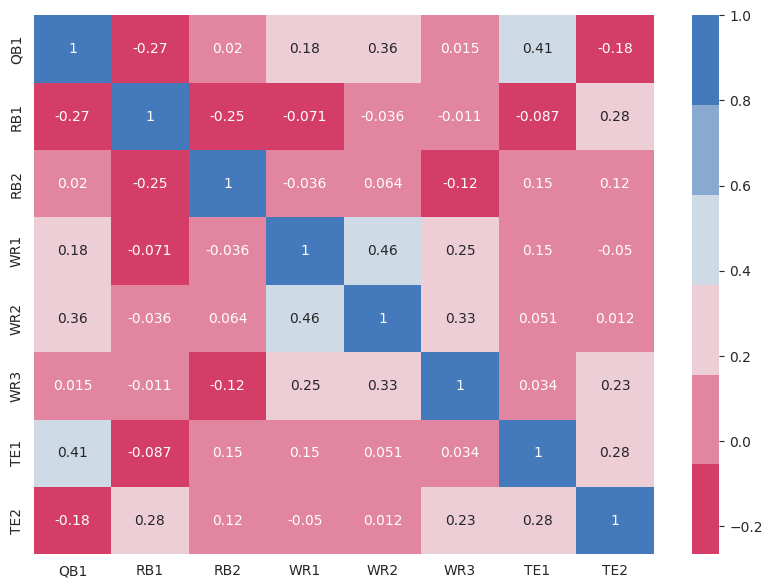

In [21]:
import seaborn as sns
from matplotlib import pyplot as plt
sns.set_style('whitegrid');
plt.figure(figsize=(10, 7))
"""
sns.diverging palette gets us back an object that can alter the colormap of our visualization.

"""
sns.heatmap(corr_df.corr(), annot=True, cmap=sns.diverging_palette(0, 250));
